In [1]:
import matplotlib.pyplot as plt
import numpy as np
from custom_poling.core.target import Target
from custom_poling.core.custom_crystal import CustomCrystal
from Functions import Total_prop, JSA, FtS
from matplotlib.animation import FuncAnimation

In [2]:
#Parameters
Np = 0.0172 # 0.000002 for low gain which agrees well ish
vp = 0.1  # pump velocity
l = 1.0  # amplification region length
sig = 1  # pump wave packet spread
a = 1.61 / 1.13  # from symmetric grp vel matching

def symmetric_v(vp, sig, l, a):
    vi = vp / (1 - 2 * a * vp / (l * sig))
    vs = vp / (1 + 2 * a * vp / (l * sig))
    return vs, vi

vs, vi = symmetric_v(vp, sig, l, a)


Ndomain = 1000
dz = (l) / Ndomain

# Crystal properties
domain_width = dz
number_domains = Ndomain
L = number_domains * domain_width
k0 = np.pi / domain_width

# Numerical integration parameters for Crystal Structure
k_range = 100/L
dk = k_range/401
k_array = np.arange(k0-k_range/2,k0+k_range/2,dk)

#For numerical FT
nk=201
k_ft = 200/L
dk = k_ft/nk
k = np.arange(-k_ft/2,k_ft/2,dk)

In [3]:
# Create a custom crystal object
custom_crystal_gauss = CustomCrystal(domain_width,number_domains)
domain_middles_gauss = custom_crystal_gauss.domain_middles

#Define and plot the target function
std = 10
height = 0.025
target_pmf_gauss = lambda k:1j*height*np.exp(-(k-k0)**2/(2*std**2))*np.exp(1j * L/2 * k)
target_gauss = Target(target_pmf_gauss,k_array)

# Compute and plot the target amplitude
target_amplitude_gauss = target_gauss.compute_amplitude(k0,domain_middles_gauss)

# Compute and plot the custom domains
custom_domains_gauss = custom_crystal_gauss.compute_domains(target_amplitude_gauss,k0)
domain = custom_domains_gauss * np.asarray([1, -1] * int(Ndomain / 2)+[1])

# defining gaussian pump pulse
def pump(x, scale=1):
    return np.exp(-((x) ** 2) / (2 * ((vp/sig)*scale) ** 2)) / np.power(np.pi * ((vp/sig)*scale)**2, 1 / 4)

#Proper scale factor
sc=std/(2*a)

In [4]:
#For a tophat potential
domain=np.asarray([1] * int(Ndomain)+[1])
sc=1

In [5]:
#Defining pump envelope and dispersion relations
Lambda =lambda x,t: np.sqrt(Np)*pump(x+l-vp*t,scale=1/sc)  #0.6*l here serves as z0, really just determined by spread
z_list = domain_middles_gauss-l/2
ws = vs*k
wi = vi*k
t=np.arange(0,20,0.5)



In [9]:
Lambda =lambda x,t: np.sqrt(Np)

In [10]:
K = Total_prop(domain,Lambda,z_list,k,t,ws,wi)

In [11]:
J, Ns, Schmidt, M, Nums, Numi = JSA(K,dk)

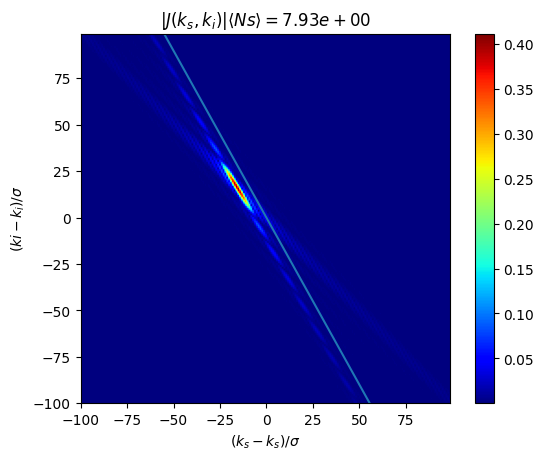

(0.41130897809197303, 7.92688424976868, 5.882561768120054)

In [12]:
fig, ax = plt.subplots()
im = ax.imshow(J, cmap="jet", origin="lower", extent=[k[0],k[nk-1],k[0],k[nk-1]])
ax.plot(-(vs/vi)*k,k)
ax.set_xlabel(r"$(k_{s}-k_{s})/\sigma$")
ax.set_ylabel(r"$(k{i}-k_{i})/\sigma$")
ax.set_title(r"$|J(k_{s}, k_{i})|    \langle Ns \rangle = %1.2e $" %Ns)
plt.colorbar(im, orientation="vertical")
plt.show()

np.amax(J),Ns,Schmidt

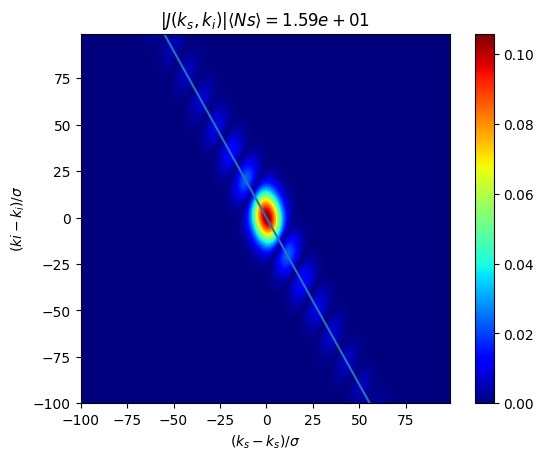

In [11]:
#Low gain solution for top-hat potential

Jtheory = np.abs(np.power(np.pi * ((vp/sig))**2, -1 / 4)*np.sqrt(Np*vp)*np.exp(-(wi + ws[:,np.newaxis])**2/2)*np.sinc((a / np.pi) * (wi - ws[:,np.newaxis])))
fig, ax = plt.subplots()
im = ax.imshow(Jtheory, cmap="jet", origin="lower", extent=[k[0],k[nk-1],k[0],k[nk-1]])
ax.plot(-(vs/vi)*k,k)
ax.set_xlabel(r"$(k_{s}-k_{s})/\sigma$")
ax.set_ylabel(r"$(k{i}-k_{i})/\sigma$")
ax.set_title(r"$|J(k_{s}, k_{i})|    \langle Ns \rangle = %1.2e $" %Ns)
plt.colorbar(im, orientation="vertical")
plt.show()


In [61]:
#Comparing and making sure that my lowgain result agrees with theory for the top-hat potential
Jn = J / np.linalg.norm(J)
Jtn = Jtheory / np.linalg.norm(Jtheory)
np.sum(Jn * np.conjugate(Jtn))

0.9999711703318107

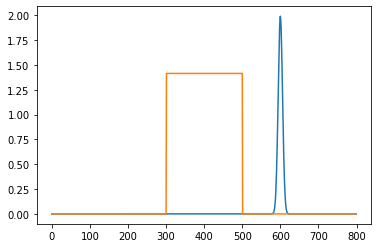

In [39]:
#Plotting the pump pulse to make sure chosen values of z0 and tf are good (i.e. pulse is completely out of crystal before and after)
zplot=np.arange(-2,2,0.005)
hat = np.sqrt(Np)*(np.heaviside(zplot+0.5,0)-np.heaviside(zplot-0.5,0))
plt.plot(Lambda(zplot,20))
plt.plot(hat)

In [8]:
#Trying to remove free propagating phases which don't give anything "useful". OK so this is how to do it for single pass
T=K
N = len(T)
ks = -vs
ki = vi
l=t[-1]
Uss = (
    np.diag(np.exp(-1j * ks * k * l / 2))
    @ T[0 : N // 2, 0 : N // 2]
    @ np.diag(np.exp(-1j * ks * k * l / 2))
)
Usi = (
     np.diag(np.exp(-1j * ks * k * l / 2))
    @ T[0 : N // 2, N // 2 : N]
    @ np.diag(np.exp(1j * ki * k * l / 2))
    )
Uiss = (
        np.diag(np.exp(1j * ki * k * l / 2))
        @ T[N // 2 : N, 0 : N // 2]
        @ np.diag(np.exp(-1j * ks * k* l / 2))
    )
Uiis = (
        np.diag(np.exp(1j * ki * k * l / 2))
        @ T[N // 2 : N, N // 2 : N]
        @ np.diag(np.exp(1j * ki * k * l / 2))
    )
U = np.block([[Uss, Usi], [Uiss, Uiis]])

Nums2 = np.conj(Usi) @ Usi.T



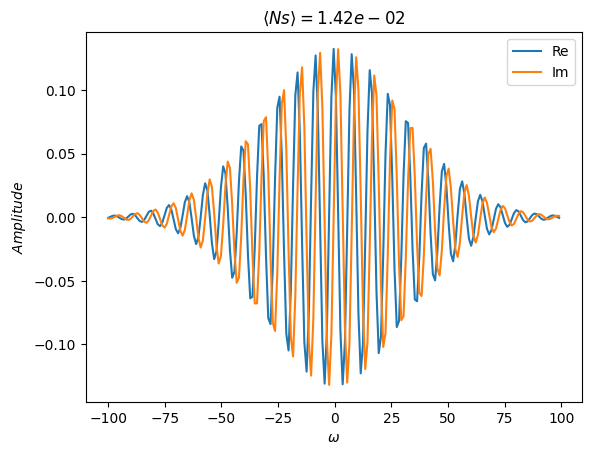

In [9]:
mark=1 #this just takes the first eigenmode of interest. Choose a different value to look at different ones.
val1, u1 = np.linalg.eigh(Nums)

fig, ax1 = plt.subplots()

ax1.plot(k, np.real(np.exp(-1j*np.angle(u1[(nk-1)//2,-mark]))*u1[:,-mark]), label='Re') #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
ax1.plot(k, np.imag(np.exp(-1j*np.angle(u1[(nk-1)//2,-mark]))*u1[:,-mark]), label='Im')
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.legend()
plt.show()

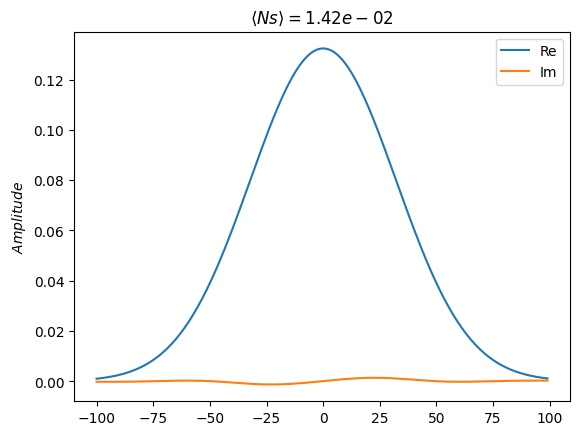

In [10]:
mark=1 #this just takes the first eigenmode of interest. Choose a different value to look at different ones.
val2, u2 = np.linalg.eigh(Nums2)

fig, ax1 = plt.subplots()
ax1.plot(k, np.real(np.exp(-1j*np.angle(u2[(nk-1)//2,-mark]))*u2[:,-mark]), label='Re') #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
ax1.plot(k, np.imag(np.exp(-1j*np.angle(u2[(nk-1)//2,-mark]))*u2[:,-mark]), label='Im')
#ax1.plot(x, np.imag(np.exp(-1j*np.angle(u1[(N-1)//2,-mark]))*u1[:,-mark]), label='Im')
#ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.legend()
plt.show()